[Open in Colab](https://colab.research.google.com/github/mizu-pumpkin/TFG2021/blob/main/sign_mnist/classifier_v1_linear_regression.ipynb)

# Imports

In [1]:
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
#from torchvision.transforms import ToTensor
#from torchvision.utils import make_grid
#from torchvision.datasets.utils import download_url
import matplotlib
import matplotlib.pyplot as plt

# indicates to Jupyter that we want to plot the graphs within the notebook
%matplotlib inline
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Image Classification generic model & functions

In [3]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### EXAMPLE MODEL CLASS
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
###

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [4]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# The problem-independent parts within a function called fit, which will be used
# to train the model. The problem-specific parts will be implemented by adding
# new methods to the nn.Module class.
# Configurations like batch size, learning rate, etc. (called hyperparameters),
# need to be picked in advance while training machine learning models.
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [5]:
def plot_accuracies(history):
    accuracies = [r['val_acc'] for r in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# Utils

In [6]:
# Utilities for moving out data & labels to the GPU, if one is available.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

/home/marisolzucca/miniconda3/envs/py37mizu/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Training an image classifier for ASL word-level recognition

## Load and normalize sign-MNIST datasets

In [7]:
# Other constants
num_rows = 27455
input_size = 28*28
output_size = 26

def int_to_char(num):
    return chr(num+65)

def plot_dataset(dataset):
    plt.figure(figsize=(9,7))
    for i in range(6):
        plt.subplot(2,3,i+1)
        image, label = dataset[i]
        plt.imshow(image.reshape(1,28,28)[0], cmap='gray')
        plt.xlabel(int_to_char(label.item()))
    plt.show()

In [8]:
# Load train dataframe
dataframe_raw = pd.read_csv('./dataset/sign_mnist_train.csv')
dataframe_raw

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


Train dataset


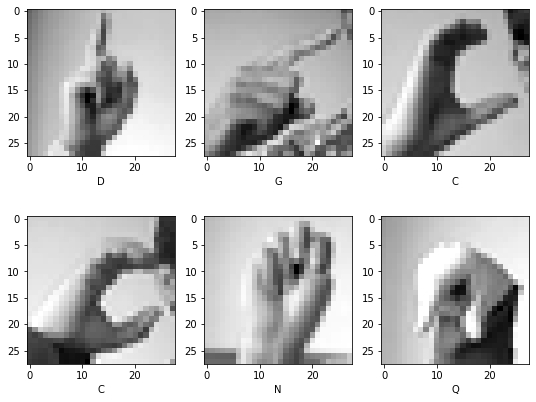

In [9]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.drop(['label'], axis=1).to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_arrays(dataframe_raw)

inputs = torch.from_numpy(inputs_array).type(torch.FloatTensor)
targets = torch.from_numpy(targets_array).type(torch.LongTensor)

# Train Dataset
dataset = TensorDataset(inputs, targets)
print('Train dataset')
plot_dataset(dataset)

Test dataset


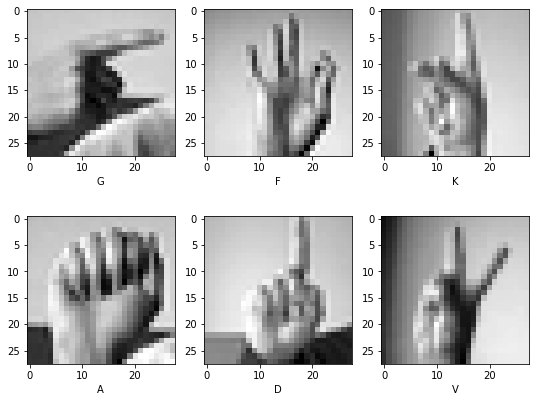

In [10]:
# Load test dataframe
df_test = pd.read_csv('./dataset/sign_mnist_test.csv')

test_inputs_array, test_targets_array = dataframe_to_arrays(df_test)

test_inputs = torch.from_numpy(test_inputs_array).type(torch.FloatTensor)
test_targets = torch.from_numpy(test_targets_array).type(torch.LongTensor)

# Test Dataset
test_ds = TensorDataset(test_inputs, test_targets)
print('Test dataset')
plot_dataset(test_ds)

## Train for classification with logistic regression

In [11]:
val_size = int(num_rows * 0.15)
train_size = num_rows - val_size

# Training validation
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(23337, 4118)

In [12]:
batch_size = 128

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

In [13]:
class SignMnistModel(ImageClassificationBase):
    # we instantiate the weights and biases using nn.Linear
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    # the forward method is invoked when we pass a batch of inputs to the model
    def forward(self, xb):
        # we flatten the input tensor and pass it into self.linear
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out

In [14]:
learning_rate = 0.01

# Training the model
model = SignMnistModel()

history = [evaluate(model, val_loader)]
print(history)

history += fit(2, learning_rate, model, train_loader, val_loader)
history += fit(2, learning_rate, model, train_loader, val_loader)
history += fit(2, learning_rate/10, model, train_loader, val_loader)

[{'val_loss': 195.76028442382812, 'val_acc': 0.04595588147640228}]
Epoch [0], val_loss: 38073.6328, val_acc: 0.0936
Epoch [1], val_loss: 13410.0645, val_acc: 0.3355
Epoch [0], val_loss: 14277.8535, val_acc: 0.3071
Epoch [1], val_loss: 10146.2051, val_acc: 0.4248
Epoch [0], val_loss: 562.6959, val_acc: 0.7993
Epoch [1], val_loss: 485.6190, val_acc: 0.8193


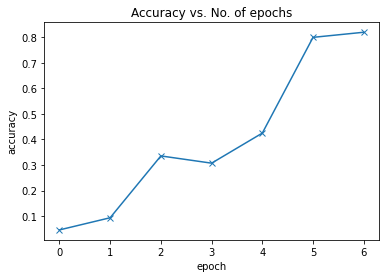

In [15]:
plot_accuracies(history)

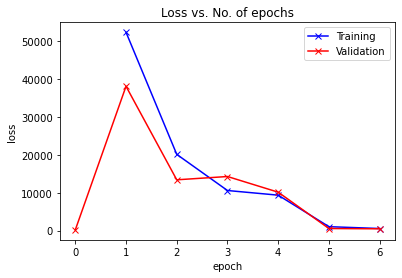

In [16]:
plot_losses(history)

In [17]:
# Save a model
# The .state_dict method returns an OrderedDict containing all the weights and
# bias matrices mapped to the right attributes of the model.
torch.save(model.state_dict(), './models/classifier_v1.pth')

## To load the model weights, we can instante a new object of the class
## MyModel, and use the .load_state_dict method.
#my_model = MyModel()
#my_model.load_state_dict(torch.load('sign-mnist-logistic.pth'))

## Test

In [18]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 1271.553466796875, 'val_acc': 0.665678858757019}

In [19]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

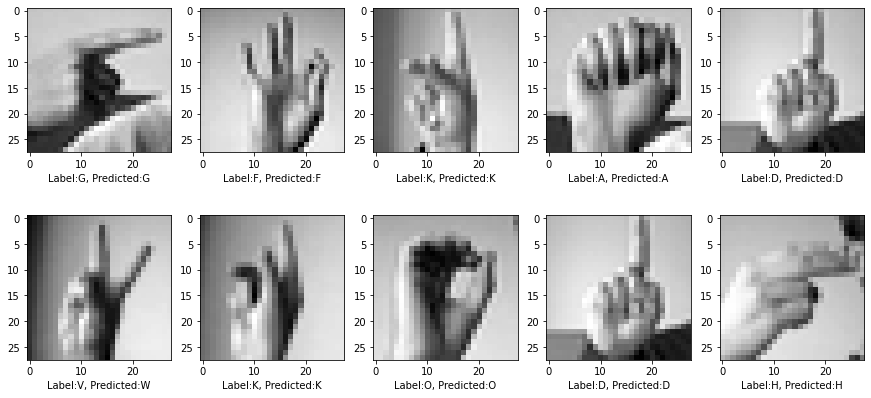

In [20]:
def plot_prediction(dataset):
    plt.figure(figsize=(15,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        image, label = dataset[i]
        plt.imshow(image.reshape(1,28,28)[0], cmap='gray')
        lbl = 'Label:'+int_to_char(label.item())+', Predicted:'+int_to_char(predict_image(image, model))
        plt.xlabel(lbl)
    plt.show()

plot_prediction(test_ds)